In [579]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import random, randrange, choice
from datetime import datetime, timedelta
from itertools import combinations
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # Cell의 모든 반환값 출력

# 기본 데이터 세팅

In [580]:
블록원데이터 = pd.DataFrame({"블록명":["S1", "S2", "S3", "S4"], 
                    "중량": [50, 60, 30, 20], 
                    "가로": [10, 10, 5, 5], 
                    "세로":[10, 12, 6, 6], 
                    "표준공기":[2, 3, 1, 2], 
                    "납기":["2024-02-15", "2024-02-15", "2024-02-15", "2024-02-15"],
                    "정반배치":[0, 0, 0, 0]})
블록원데이터.head()

,블록명,중량,가로,세로,표준공기,납기,정반배치
0,S1,50,10,10,2,2024-02-15,0
1,S2,60,10,12,3,2024-02-15,0
2,S3,30,5,6,1,2024-02-15,0
3,S4,20,5,6,2,2024-02-15,0


In [581]:
정반원데이터 = pd.DataFrame({"정반명":["A", "B", "C"],
                   "가능중량":[100, 100, 30],
                   "가로":[10, 10, 5],
                   "세로":[20, 10, 10],
                   })
정반원데이터.head()

,정반명,가능중량,가로,세로
0,A,100,10,20
1,B,100,10,10
2,C,30,5,10


In [582]:
정반원데이터.index[정반원데이터["정반명"]=="B"].values[0]

1

In [583]:
start_date = datetime(2024, 2, 1)
end_date = datetime(2024, 2, 28)
날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
날짜집합

DatetimeIndex(['2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',
               '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
               '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12',
               '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16',
               '2024-02-17', '2024-02-18', '2024-02-19', '2024-02-20',
               '2024-02-21', '2024-02-22', '2024-02-23', '2024-02-24',
               '2024-02-25', '2024-02-26', '2024-02-27', '2024-02-28'],
              dtype='datetime64[ns]', freq='D')

In [584]:
블록집합 = 블록원데이터["블록명"].unique().tolist()
블록집합

['S1', 'S2', 'S3', 'S4']

In [585]:
최초정반집합 = 정반원데이터["정반명"].unique().tolist()
최초정반집합

['A', 'B', 'C']

# 블록 데이터 전처리 함수

In [586]:
import functools
def unpack_df_columns(func):
    @functools.wraps(func)
    def _unpack_df_columns(*args, **kwargs):
        series = args[0]
        return func(*series.values)
    return _unpack_df_columns

In [587]:
@unpack_df_columns
def 최소착수요구일구하기(납기, 공기):
    result = pd.to_datetime(납기) - timedelta(days=int(공기))
    return result.date()

In [731]:
착수일가중치, 공기가중치, 크기가중치 = 0.7, 0.5, 0.5

@unpack_df_columns
def 블록우선순위구하기(날순, 공순, 크순):
    global 착수일가중치, 공기가중치, 크기가중치
    result = np.round((날순*착수일가중치 + 공순*공기가중치 + 크순*크기가중치)/3,1)
    return result

@unpack_df_columns
def 사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)
    result = (길이2, 길이1)
    return result

In [732]:
def 블록데이터전처리(블록원데이터):
    df1 = 블록원데이터.copy()
    df1["사이즈"] = df1[["가로", "세로"]].apply(사이즈튜플만들기, axis=1)
    df1["납기"] = pd.to_datetime(df1["납기"])
    df1["면적"] = df1.eval("가로*세로")
    df1["최소착수요구일"] = df1[["납기", "표준공기"]].apply(최소착수요구일구하기, axis=1)
    df1["날짜순서"] = df1["최소착수요구일"].rank()
    df1["공기순서"] = df1["표준공기"].rank(ascending=False)
    df1["크기순서"] = df1["면적"].rank(ascending=False)
    df1["우선순위"] = df1[["날짜순서", "공기순서", "크기순서"]].apply(블록우선순위구하기, axis=1)
    
    df1 = df1.drop(['가로', '세로'], axis=1)
    df1 = df1.sort_values(by=["우선순위"])
    return df1

In [733]:
df1 = 블록데이터전처리(블록원데이터)
df1

,블록명,중량,표준공기,납기,정반배치,사이즈,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위
1,S2,60,9,2024-02-14,0,"(10, 12)",120,2024-02-05,1.0,1.0,1.0,0.6
0,S1,50,8,2024-02-15,0,"(10, 10)",100,2024-02-07,3.0,2.0,2.0,1.4
3,S4,20,6,2024-02-12,0,"(5, 6)",30,2024-02-06,2.0,3.0,3.5,1.6
2,S3,30,5,2024-02-13,0,"(5, 6)",30,2024-02-08,4.0,4.0,3.5,2.2


In [734]:
공기가중치 = [9, 0.5]
크기가중치 = [0.5, 9]
착수일가중치 = 0.5
for 공기가중치, 크기가중치 in zip(공기가중치, 크기가중치):
    df2 = 블록데이터전처리(블록원데이터)
    print(df2[["블록명", "우선순위"]])

  블록명  우선순위
1  S2   3.3
0  S1   6.8
3  S4   9.9
2  S3  13.2
  블록명  우선순위
1  S2   3.3
0  S1   6.8
3  S4  11.3
2  S3  11.8


# 정반 데이터 전처리 함수

In [735]:
중량가중치, 크기가중치 = 0.5, 0.7

@unpack_df_columns
def 정반우선순위구하기(중순, 크순):
    global 중량가중치, 크기가중치
    result = np.round((중순*중량가중치 + 크순*크기가중치)/3,1)
    return result

In [736]:
def 정반데이터전처리(정반원데이터):
    df = 정반원데이터.copy()
    
    df["사이즈"] = df[["가로", "세로"]].apply(사이즈튜플만들기, axis=1)
    df["면적"] = df.eval("가로*세로")
    df["중량순서"] = df["가능중량"].rank(ascending=False)
    df["크기순서"] = df["면적"].rank(ascending=False)
    df["우선순위"] = df[["중량순서", "크기순서"]].apply(정반우선순위구하기, axis=1)
    
    df = df.drop(['가로', '세로'], axis=1)
    df = df.sort_values(by=["우선순위"])
    return df

In [737]:
df2 = 정반데이터전처리(정반원데이터)
df2

,정반명,가능중량,사이즈,면적,중량순서,크기순서,우선순위
0,A,100,"(20, 20)",400,1.5,1.0,0.5
1,B,100,"(15, 20)",300,1.5,2.0,0.7
2,C,30,"(10, 20)",200,3.0,3.0,1.2


In [738]:
중량가중치들 = [0.9, 0.01]
크기가중치들 = [0.01, 3]

for 중량가중치, 크기가중치 in zip(중량가중치들, 크기가중치들):
    df2 = 정반데이터전처리(정반원데이터)
    print(df2[["정반명", "우선순위"]])

  정반명  우선순위
0   A   0.5
1   B   0.5
2   C   0.9
  정반명  우선순위
0   A   1.0
1   B   2.0
2   C   3.0


# 달력 함수 정의

## 배치달력함수

In [739]:
def create_init_calendar(시작년:int, 시작월:int, 종료년:int, 종료월:int, 정반집합):
    start_date = datetime(시작년, 시작월, 1)
    end_date = datetime(종료년, 종료월, 28)
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    배치달력 = pd.DataFrame()
    배치달력.index = 날짜집합
   
    for 정반 in 정반집합:
        배치달력[f"{정반}"] = 0

    return 배치달력

In [740]:
최초정반집합 = 정반원데이터["정반명"].unique().tolist()
배치달력 = create_init_calendar(2024, 2, 2024, 2, 최초정반집합)
배치달력

,A,B,C
2024-02-01,0,0,0
2024-02-02,0,0,0
2024-02-03,0,0,0
2024-02-04,0,0,0
2024-02-05,0,0,0
2024-02-06,0,0,0
2024-02-07,0,0,0
2024-02-08,0,0,0
2024-02-09,0,0,0
2024-02-10,0,0,0


In [807]:
def update_배치달력(배치달력, 정반명, 착수날짜, 필요공기):
    
    정반집합 = 배치달력.columns.tolist()
    신규칼럼리스트 = 정반집합.copy()
#     print(f"배치달력칼럼리스트: {배치달력.columns}, 신규칼럼리스트: {신규칼럼리스트}")
    try:
        for 현칼럼 in 배치달력.columns:
            신규칼럼리스트.remove(현칼럼)  # 신규칼럼만 남기기 위해

        for 신규칼럼 in 신규칼럼리스트:
            # 신규칼럼에는 모정반의 배치달력 정보를 카피(모정반의 제약조건을 승계하도록)
            배치달력[f"{신규칼럼}"] = 배치달력[f"{신규칼럼[:1]}"]

        시점인덱스 = list(배치달력.index.strftime('%Y-%m-%d')).index(착수날짜)
        배치달력[f"{정반명}"].iloc[시점인덱스:시점인덱스+필요공기] = 1
        return 배치달력
    
    except:
        return 배치달력

## 공기달력 함수

In [808]:
def create_공기달력(배치달력, 날짜집합):
    total_list = []
    정반집합 = 배치달력.columns.tolist()

    for 정반 in 정반집합:
        검토대상 = 배치달력[f"{정반}"].tolist()

        new_list = []
        new_num = 0
        for idx, i in enumerate(검토대상):
            if i == 0:
                new_num = new_num  + 1
                new_list.append(new_num)
            else:
                new_list.append(0)
                new_num = 0
        total_list.append(new_list)
        
    new_total = []
    for original_list in total_list:

        result_list = []
        group = []
        for num in original_list:
            if num == 0 and group:
                result_list.extend(reversed(group))
                group = []
            group.append(num)

        result_list.extend(reversed(group))

        new_total.append(result_list)

    공기달력 = pd.DataFrame()
    공기달력.index = 날짜집합

    for idx, 정반 in enumerate(정반집합):
        공기달력[f"{정반}"] =  new_total[idx]

    for 정반 in 정반집합:
        if 공기달력[f"{정반}"][0]== 0:
            공기달력[f"{정반}"] = 공기달력[f"{정반}"].shift(1)
        else:
            pass
    공기달력.fillna(0, inplace=True)
    return 공기달력

## 공백순서달력(first_zero) 함수

In [809]:
def create_공백순서달력(배치달력, 날짜집합):
    total = []
    정반집합 = 배치달력.columns.tolist()

    for 정반 in 배치달력.columns.tolist():
        
        input_list = 배치달력[f"{정반}"].tolist()
        
        counter = 1
        result_list = []

        for idx, x in enumerate(input_list):

            if idx == 0:
                if x == 1:
                    result_list.append(0)
                else:
                    result_list.append(counter)
                    counter += 1

            else:   
                if input_list[idx-1] == 1 and x == 0:
                    result_list.append(counter)
                    counter += 1
                else:
                    result_list.append(0)

        total.append(result_list)

    공백순서달력 = pd.DataFrame()
    공백순서달력.index = 날짜집합

    for idx, 정반 in enumerate(배치달력.columns.tolist()):
        공백순서달력[f"{정반}"] =  total[idx]

    return 공백순서달력

In [810]:
공백순서달력 = create_공백순서달력(배치달력, 날짜집합)
공백순서달력

,A,B,C
2024-02-01,1,1,1
2024-02-02,0,0,0
2024-02-03,0,0,0
2024-02-04,0,0,0
2024-02-05,0,0,0
2024-02-06,0,0,0
2024-02-07,0,0,0
2024-02-08,0,0,0
2024-02-09,0,0,0
2024-02-10,0,0,0


## 착수가능일찾기 함수

In [811]:
def 착수가능일찾기(공기달력, 공백순서달력, 정반, 표준공기):
    first_zeros = []
    
    for idx, i in enumerate(공백순서달력[f"{정반}"].tolist()):
        if i != 0:
            first_zeros.append(공백순서달력.index.strftime('%Y-%m-%d').values[idx])

    for idx, 착수가능일 in enumerate(first_zeros):
        착수가능일인덱스 = list(공기달력.index.strftime('%Y-%m-%d')).index(first_zeros[idx])
        착수가능일의확보가능공기 = 공기달력[f"{정반}"].iloc[착수가능일인덱스]
        
        if 착수가능일의확보가능공기 > 표준공기:
            return 착수가능일 
        else:
            pass

# 간트차트 함수

In [812]:
import plotly.express as px
def draw_gant(df):
    fig = px.timeline(
        
        df, 
        x_start="착수일", 
        x_end="종료일", 
        y="정반명",
        color="정반구분",
        hover_data = ["표준공기", "조립중량"],
        text = "차트텍스트",
        opacity=0.7
        )

    fig.update_yaxes(autorange="reversed")          #if not specified as 'reversed', the tasks will be listed from bottom up       
    fig.update_layout(
                    # title='Project Plan Gantt Chart',
                    hoverlabel_bgcolor='#DAEEED',   #Change the hover tooltip background color to a universal light blue color. If not specified, the background color will vary by team or completion pct, depending on what view the user chooses
                    bargap=0.2,
                    height=500,              
                    xaxis_title="", 
                    yaxis_title="정반명", 
                    font=dict(
                        family="Courier New, monospace",
                        size=12,  # Set the font size here
                        color="RebeccaPurple"
                        ),
    )
    fig.show()

# 달력생성 및 업데이트 연습

## 최초달력생성

In [813]:
배치달력 = create_init_calendar(2024, 2, 2024, 2, 최초정반집합)
배치달력.iloc[:2,:] = 1   ## 날짜 계산의 편의를 위해 초반 2일을 배치상태로 설정
배치달력

,A,B,C
2024-02-01,1,1,1
2024-02-02,1,1,1
2024-02-03,0,0,0
2024-02-04,0,0,0
2024-02-05,0,0,0
2024-02-06,0,0,0
2024-02-07,0,0,0
2024-02-08,0,0,0
2024-02-09,0,0,0
2024-02-10,0,0,0


In [814]:
정반집합 = 배치달력. columns.tolist()
공기달력 = create_공기달력(배치달력, 날짜집합)
공기달력

,A,B,C
2024-02-01,0.0,0.0,0.0
2024-02-02,0.0,0.0,0.0
2024-02-03,26.0,26.0,26.0
2024-02-04,25.0,25.0,25.0
2024-02-05,24.0,24.0,24.0
2024-02-06,23.0,23.0,23.0
2024-02-07,22.0,22.0,22.0
2024-02-08,21.0,21.0,21.0
2024-02-09,20.0,20.0,20.0
2024-02-10,19.0,19.0,19.0


In [815]:
공백순서달력 = create_공백순서달력(배치달력, 날짜집합)
공백순서달력

,A,B,C
2024-02-01,0,0,0
2024-02-02,0,0,0
2024-02-03,1,1,1
2024-02-04,0,0,0
2024-02-05,0,0,0
2024-02-06,0,0,0
2024-02-07,0,0,0
2024-02-08,0,0,0
2024-02-09,0,0,0
2024-02-10,0,0,0


## 블록배치

In [816]:
착수가능일 = 착수가능일찾기(공기달력, 공백순서달력, "A", 13)
착수가능일

'2024-02-03'

## 달력 업데이트

In [817]:
새정반집합 = ["A","B","C","A_1"]
배치달력 = update_배치달력(배치달력, "A", "2024-02-03", 2)
배치달력

,A,B,C
2024-02-01,1,1,1
2024-02-02,1,1,1
2024-02-03,1,0,0
2024-02-04,1,0,0
2024-02-05,0,0,0
2024-02-06,0,0,0
2024-02-07,0,0,0
2024-02-08,0,0,0
2024-02-09,0,0,0
2024-02-10,0,0,0


In [818]:
공기달력 = create_공기달력(배치달력, 날짜집합)
공기달력

,A,B,C
2024-02-01,0.0,0.0,0.0
2024-02-02,0.0,0.0,0.0
2024-02-03,0.0,26.0,26.0
2024-02-04,0.0,25.0,25.0
2024-02-05,24.0,24.0,24.0
2024-02-06,23.0,23.0,23.0
2024-02-07,22.0,22.0,22.0
2024-02-08,21.0,21.0,21.0
2024-02-09,20.0,20.0,20.0
2024-02-10,19.0,19.0,19.0


In [753]:
공백순서달력 = create_공백순서달력(배치달력, 날짜집합)
공백순서달력

,A,B,C,A_1
2024-02-01,0,0,0,0
2024-02-02,0,0,0,0
2024-02-03,0,1,1,1
2024-02-04,0,0,0,0
2024-02-05,1,0,0,0
2024-02-06,0,0,0,0
2024-02-07,0,0,0,0
2024-02-08,0,0,0,0
2024-02-09,0,0,0,0
2024-02-10,0,0,0,0


# 날짜 조건 적합도 검토

In [754]:
def 블록변수정리(블록데이터, target_block):
    블록 = dict()
    블록["블록명"] = target_block
    블록["인덱스"] =  블록데이터[블록데이터["블록명"]==target_block].index.values[0]
    블록["중량"] = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    블록["사이즈"] = 블록데이터[블록데이터["블록명"]==target_block]["사이즈"].values[0]
    블록["면적"] = 블록데이터[블록데이터["블록명"]==target_block]["면적"].values[0]
    블록["표준공기"] = 블록데이터[블록데이터["블록명"]==target_block]["표준공기"].values[0]
    블록["최소착수요구일"] = 블록데이터[블록데이터["블록명"]==target_block]["최소착수요구일"].values[0]
    return 블록

In [755]:
블록변수정리(df1, "S1")

{'블록명': 'S1',
 '인덱스': 0,
 '중량': 50,
 '사이즈': (10, 10),
 '면적': 100,
 '표준공기': 8,
 '최소착수요구일': datetime.date(2024, 2, 7)}

In [756]:
def 정반변수정리(정반데이터, 정반명):
    정반 = dict()
    정반["정반명"] = 정반명
    정반["가능중량"] = 정반데이터[정반데이터["정반명"]==정반명]["가능중량"].values[0]
    정반["사이즈"] = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    정반["면적"] = 정반데이터[정반데이터["정반명"]==정반명]["면적"].values[0]
    
    return 정반

In [757]:
A = 정반변수정리(df2, "A")
A

{'정반명': 'A', '가능중량': 100, '사이즈': (20, 20), '면적': 400}

In [758]:
def 날짜조건_가능정반dict_구하기(target_block, 블록데이터, 정반데이터, 배치달력, 공기달력, 공백순서달력):
    
    정반리스트 = 정반데이터["정반명"].unique().tolist()
    블록변수 = 블록변수정리(블록데이터, target_block)
    블록표준공기 = 블록변수["표준공기"]
    최소착수요구일 = 블록변수["최소착수요구일"]
    print(f"블록명:{target_block}, 최소착수요구일:{최소착수요구일}, 블록표준공기:{블록표준공기}")
    
    가능정반_dict = {}
    for 정반 in 정반리스트:
        
        정반변수 = 정반변수정리(정반데이터, 정반)

        공백순서1인덱스 = list(공백순서달력[f"{정반}"]).index(1)
        공백순서1인덱스의날짜 = 배치달력.index[공백순서1인덱스]
        공백순서1인덱스의날짜의확보가능공기 = 공기달력[f"{정반}"][공백순서1인덱스]
        공백순서1인덱스날짜의공백순서 = 공백순서달력[f"{정반}"][공백순서1인덱스]
        print(f">>>[검토] 정반명:{정반}, 공백순서1인덱스의날짜: {공백순서1인덱스의날짜}, 인덱스: {공백순서1인덱스}, 확보가능공기:{공백순서1인덱스의날짜의확보가능공기}")

        try:
            공백순서2인덱스 = list(공백순서달력[f"{정반}"]).index(2)
            공백순서2인덱스의날짜 = 배치달력.index[공백순서2인덱스]
            공백순서2인덱스의날짜의확보가능공기 = 공기달력[f"{정반}"][공백순서2인덱스]
            공백순서2인덱스날짜의공백순서 = 공백순서달력[f"{정반}"][공백순서2인덱스]
            print(f">>>[검토] 정반명:{정반}, 공백순서2인덱스의날짜: {공백순서2인덱스의날짜}, 인덱스: {공백순서2인덱스}, 확보가능공기:{공백순서2인덱스의날짜의확보가능공기}")
            
            if 공백순서1인덱스의날짜 <= 최소착수요구일 and 공백순서1인덱스의날짜의확보가능공기 >= 블록표준공기 and 공백순서1인덱스날짜의공백순서 == 1:
                가능정반_dict[정반] = 공백순서1인덱스의날짜
            elif 공백순서2인덱스의날짜 <= 최소착수요구일 and 공백순서2인덱스의날짜의확보가능공기 >= 블록표준공기 and 공백순서2인덱스날짜의공백순서 == 2:
                가능정반_dict[정반] = 공백순서2인덱스의날짜
            else:
                pass

        except:
            if 공백순서1인덱스의날짜 <= 최소착수요구일 and 공백순서1인덱스의날짜의확보가능공기 >= 블록표준공기 and 공백순서1인덱스날짜의공백순서 == 1:
                가능정반_dict[정반] = 공백순서1인덱스의날짜
            else:
                pass
            pass

    return 가능정반_dict

In [759]:
가능정반_dict = 날짜조건_가능정반dict_구하기("S1", df1, df2, 배치달력, 공기달력, 공백순서달력)
가능정반_dict

블록명:S1, 최소착수요구일:2024-02-07, 블록표준공기:8
>>>[검토] 정반명:A, 공백순서1인덱스의날짜: 2024-02-05 00:00:00, 인덱스: 4, 확보가능공기:24.0
>>>[검토] 정반명:B, 공백순서1인덱스의날짜: 2024-02-03 00:00:00, 인덱스: 2, 확보가능공기:26.0
>>>[검토] 정반명:C, 공백순서1인덱스의날짜: 2024-02-03 00:00:00, 인덱스: 2, 확보가능공기:26.0


{'A': Timestamp('2024-02-05 00:00:00', freq='D'),
 'B': Timestamp('2024-02-03 00:00:00', freq='D'),
 'C': Timestamp('2024-02-03 00:00:00', freq='D')}

In [760]:
def 최선조기착수가능정반(가능정반_dict):
    최선조기착수가능정반 = [key for key, value in 가능정반_dict.items() if value == min(가능정반_dict.values())]
    return 최선조기착수가능정반

In [761]:
최선조기착수가능 = 최선조기착수가능정반(가능정반_dict)
최선조기착수가능

['B', 'C']

# 정반가능중량 조건 적합도 검토

In [793]:
def 정반가능중량검토(target_block, 블록데이터, 정반, 정반데이터):
    블록중량 = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    정반가능중량 = 정반데이터[정반데이터["정반명"]==정반]["가능중량"].values[0]
    
    if 정반가능중량 > 블록중량: 
        return "적합"
    else:
        return "부적합"

In [794]:
정반가능중량검토("S1", df1, "A", df2)

'적합'

# 정반면적 조건 적합도 검토

## 함수 정의

In [762]:
def 정반세팅(사이즈):  #사이즈 = (10, 10)
    surface_width, surface_height = 사이즈[0], 사이즈[1]  # Adjusted to match the provided image for demonstration
    surface = np.zeros((surface_height, surface_width), dtype=int)
    return surface, surface_width, surface_height

In [763]:
# Function to check if a block can be placed on the surface
def can_place(surface, block, start_row, start_col):
    block_height, block_width = block
    if start_row + block_height > surface_height or start_col + block_width > surface_width:
        return False
    return np.all(surface[start_row:start_row + block_height, start_col:start_col + block_width] == 0)

# Function to place a block on the surface, if possible
def place_block(surface, block, start_row, start_col, block_id):
    block_height, block_width = block
    surface[start_row:start_row + block_height, start_col:start_col + block_width] = block_id

# Function to find the best fit for a block on the surface
def find_best_fit(surface, block, block_id):
    best_fit_score = float('inf')
    best_position = None
    block_height, block_width = block

    # Iterate over all possible positions on the surface
    for y in range(surface_height - block_height + 1):
        for x in range(surface_width - block_width + 1):
            if can_place(surface, block, y, x):
                # Calculate a score; here we use the top-left corner (y, x) as the score
                # A lower score means the block is closer to the top-left
                score = y + x
                if score < best_fit_score:
                    best_fit_score = score
                    best_position = (y, x)

    # If a best position was found, place the block there
    if best_position:
        place_block(surface, block, *best_position, block_id)
        return True
    return False  # No fit found

# Function to fit blocks on the surface in order
def fit_blocks(surface, blocks, names):
    result = ""
    block_id = max(map(max, surface))+1  # Start numbering blocks from 1
    for name, block in zip(names, blocks):
        if not find_best_fit(surface, block, block_id):
            print(f"Block {block_id} of size {block} could not be placed.")
            result = "부적합"
        else:
            result = "적합"
        block_id += 1  # Increment block_id for the next block
    return surface, result

In [764]:
# Visualize the surface with the blocks placed
def draw(surface):
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figure size to be square
    # Create a colormap with a distinct color for each block ID
    cmap = mcolors.ListedColormap(['white'] + ['C{}'.format(i) for i in range(len(block_sizes))])
    norm = mcolors.BoundaryNorm(np.arange(0.5, len(block_sizes) + 2), cmap.N)

    ax.imshow(surface, cmap=cmap, norm=norm)

    # Add gridlines and block numbers
    for y in range(surface_height):
        for x in range(surface_width):
            if surface[y, x] != 0:
                ax.text(x, y, str(block_names[surface[y, x]-1]), ha='center', va='center', color='black')
#                 ax.text(x, y, str(block_names[surface[y, x]-1]), ha='center', va='center', color='black')

    # Draw gridlines
    ax.set_xticks(np.arange(-.5, surface_width, 1), minor=True)
    ax.set_yticks(np.arange(-.5, surface_height, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)

    # Remove the major ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

## 단순시뮬

In [765]:
사이즈 = (10, 10)
surface, surface_width, surface_height = 정반세팅(사이즈)
surface, surface_width, surface_height

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 10,
 10)

In [766]:
# Define the blocks we want to place with a unique ID for each block type
block_sizes = [(2, 2), (3, 3), (2, 4), (4, 5), (2, 4), (2, 6), (2, 5), (4, 6), (2, 8), (4, 5)]  # Updated block list
block_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8","S9", "S10"]

In [767]:
# Place the blocks on the surface
results = fit_blocks(surface, block_sizes, block_names)
surface = results[0]
적합도 = results[1]

Block 8 of size (4, 6) could not be placed.
Block 9 of size (2, 8) could not be placed.
Block 10 of size (4, 5) could not be placed.


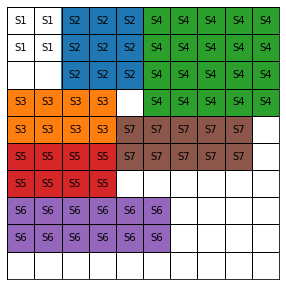

In [768]:
draw(surface)

## 실 검토 - 1차 배치

In [769]:
사이즈 = (10, 5)
surface, surface_width, surface_height = 정반세팅(사이즈)
surface, surface_width, surface_height

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 10,
 5)

In [770]:
block_sizes = []
block_names = []

In [771]:
블록사이즈 = (3, 10)
블록명 = "A"
block_size = [블록사이즈]
block_name = [블록명]
block_size, block_name

([(3, 10)], ['A'])

In [772]:
result = fit_blocks(surface, block_size, block_name)
적합도 = result[1]
적합도

'적합'

In [773]:
block_sizes.append(블록사이즈)
block_names.append(블록명)
surface, surface_width, surface_height = 정반세팅(사이즈)

In [775]:
# Place the blocks on the surface
results = fit_blocks(surface, block_sizes, block_names)
surface = results[0]
surface

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

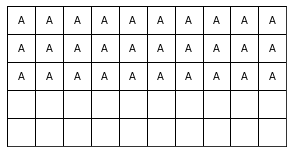

In [776]:
draw(surface)

In [777]:
block_size = [(2, 4)]
block_name = ["B"]
block_size, block_name

([(2, 4)], ['B'])

In [778]:
result = fit_blocks(surface, block_size, block_name)
적합도 = result[1]
적합도

'적합'

In [779]:
block_sizes = block_sizes + block_size
block_names = block_names + block_name
block_sizes, block_names

surface, surface_width, surface_height = 정반세팅(사이즈)

([(3, 10), (2, 4)], ['A', 'B'])

In [780]:
# Place the blocks on the surface
results = fit_blocks(surface, block_sizes, block_names)
surface = results[0]
적합도 = results[1]
surface
적합도

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 0, 0, 0, 0, 0, 0]])

'적합'

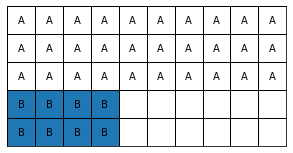

In [781]:
draw(surface)

# 생산계획수립

In [804]:
def 생산계획수립(블록데이터, 정반데이터, 배치달력):
    
    수정블록리스트 = 블록데이터["블록명"].tolist()
    
    공기달력 = create_공기달력(배치달력, 날짜집합)
    공백순서달력 = create_공백순서달력(배치달력,날짜집합)
    
    block_sizes = []
    block_names = []
    
    for _ in tqdm(range(len(수정블록리스트))):
        
        if 수정블록리스트:
            target_block = 수정블록리스트[0]
            
        else:
            print("수정블록리스트에 잔여블록이 없습니다.")
            print()
            break
            
        블록변수 = 블록변수정리(블록데이터, target_block)
        블록명 = 블록변수["블록명"]
        블록사이즈 = 블록변수["사이즈"]
        print(f"블록사이즈타입: {type(블록사이즈)}")
        x, y = 블록사이즈
        블록역사이즈 = (y, x)
        
        ## CHECK 날짜 조건 -------------------------------------------------------------------------------------
        날짜조건적합정반 = 날짜조건_가능정반dict_구하기(target_block, 블록데이터, 정반데이터, 배치달력, 공기달력, 공백순서달력)
        print(f"블록{target_block}의 날짜조건적합정반: {날짜조건적합정반}")
        
        최선조기착수가능 = 최선조기착수가능정반(날짜조건적합정반)
        print(f"블록{target_block}의 최선조기착수가능정반: {최선조기착수가능}")
        
        ## 중량 조건 -------------------------------------------------------------------------------------
        중량조건적합정반 = []
        
        for 정반 in 최선조기착수가능:
            검토결과 = 정반가능중량검토(target_block, 블록데이터, 정반, 정반데이터)
            if 검토결과 == "적합":
                중량조건적합정반.append(정반)
            else:
                pass
        print(f"중량조건적합정반: {중량조건적합정반}")
        
        ## 면적 조건 -------------------------------------------------------------------------------------
        랜덤선택정반 = choice(중량조건적합정반)
        print(f"랜덤선택정반: {랜덤선택정반}")
        
        정반변수 = 정반변수정리(정반데이터, 랜덤선택정반)
        사이즈 = 정반변수["사이즈"]
        print(f"정반사이즈: {사이즈}")

        block_size = [블록사이즈]
        rev_block_size = [블록역사이즈]
        block_name = [블록명]
        print(f"블록사이즈: {block_size}, 블록역사이즈: {rev_block_size}, 블록명: {block_name}")

        surface, surface_width, surface_height = 정반세팅(사이즈)
        result1 = fit_blocks(surface, block_size, block_name)
        적합도1 = result1[1]

        surface, surface_width, surface_height = 정반세팅(사이즈) 
        result2 = fit_blocks(surface, rev_block_size, block_name)
        적합도2 = result2[1]

        print(f"*** 적합도1: {적합도1}, 적합도2: {적합도2}")
        print()
                
        if 적합도1 == "적합":
            block_names.append(블록명)
            block_sizes.append(블록사이즈)
            print(f"block_names: {block_names}")
            print(f"block_sizes: {block_sizes}")
            
            surface, surface_width, surface_height = 정반세팅(사이즈)
            results = fit_blocks(surface, block_sizes, block_names)
            
            surface = results[0]
            수정블록리스트.remove(블록명)
        
        elif 적합도2 == "적합":
            block_names.append(블록명)
            block_sizes.append(블록역사이즈)
            print(f"block_names: {block_names}")
            print(f"block_sizes: {block_sizes}")
            
            surface, surface_width, surface_height = 정반세팅(사이즈)
            results = fit_blocks(surface, block_sizes, block_names)
            
            surface = results[0]
            수정블록리스트.remove(블록명)
        
        else:
            수정블록리스트.remove(블록명)
            print("물리적으로 배치할 수 없습니다.")
            
        print(f"수정블록리스트: {수정블록리스트}")
        
        ##### 달력 1차 업데이트 ############
        배치달력 =  update_배치달력(배치달력, 랜덤최선정반, 착수가능일, 블록_표준공기, 수정정반리스트) 
        공기달력 = create_공기달력(배치달력, 날짜집합, 수정정반리스트)
        공백순서달력 = create_공백순서달력(배치달력, 수정정반리스트, 날짜집합)
        
        print("="* 70)
            

    return surface, 배치달력, 공기달력, 공백순서달력

In [805]:
data_num = 1

블록원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="블록데이터")
정반원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="정반데이터")

블록데이터 = 블록데이터전처리(블록원데이터)
정반데이터 = 정반데이터전처리(정반원데이터)
배치달력 = create_init_calendar(2024, 2, 2024, 2, 최초정반집합)

In [806]:
surface = 생산계획수립(블록데이터, 정반데이터, 배치달력)

100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 51.94it/s]

블록사이즈타입: <class 'tuple'>
블록명:S2, 최소착수요구일:2024-02-05, 블록표준공기:9
>>>[검토] 정반명:A, 공백순서1인덱스의날짜: 2024-02-01 00:00:00, 인덱스: 0, 확보가능공기:28
>>>[검토] 정반명:B, 공백순서1인덱스의날짜: 2024-02-01 00:00:00, 인덱스: 0, 확보가능공기:28
>>>[검토] 정반명:C, 공백순서1인덱스의날짜: 2024-02-01 00:00:00, 인덱스: 0, 확보가능공기:28
블록S2의 날짜조건적합정반: {'A': Timestamp('2024-02-01 00:00:00', freq='D'), 'B': Timestamp('2024-02-01 00:00:00', freq='D'), 'C': Timestamp('2024-02-01 00:00:00', freq='D')}
블록S2의 최선조기착수가능정반: ['A', 'B', 'C']
중량조건적합정반: ['A', 'B']
랜덤선택정반: B
정반사이즈: (15, 20)
블록사이즈: [(10, 12)], 블록역사이즈: [(12, 10)], 블록명: ['S2']
Block 1 of size (10, 12) could not be placed.
Block 1 of size (12, 10) could not be placed.
*** 적합도1: 부적합, 적합도2: 부적합

물리적으로 배치할 수 없습니다.
수정블록리스트: ['S1', 'S4', 'S3']
블록사이즈타입: <class 'tuple'>
블록명:S1, 최소착수요구일:2024-02-07, 블록표준공기:8
>>>[검토] 정반명:A, 공백순서1인덱스의날짜: 2024-02-01 00:00:00, 인덱스: 0, 확보가능공기:28
>>>[검토] 정반명:B, 공백순서1인덱스의날짜: 2024-02-01 00:00:00, 인덱스: 0, 확보가능공기:28
>>>[검토] 정반명:C, 공백순서1인덱스의날짜: 2024-02-01 00:00:00, 인덱스: 0, 확보가능공기:28
블록S1의 날짜조건적합정반

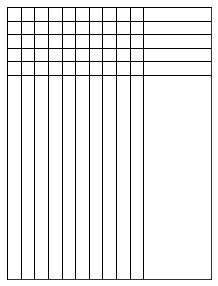

In [788]:
draw(surface)

# 메모
- 자식정반을 만들지 않고, 잔여면적 체크를 위해 면적달력 추가 필요
- 면적배치 단계에서 에러 발생중.. 왜?